In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow_datasets as tfds
import time
from spn_3.spn import SPN
from utils import train, count_parameters, apply_lth_pruning, clean_weights, merge_weights


In [25]:
# Set the seed for PyTorch (CPU and GPU)
torch.manual_seed(42)

torch.cuda.manual_seed(42)
torch.cuda.manual_seed_all(42)

In [26]:
#hyperparameters
batch_size = 32
learning_rate = 1e-2
epochs = 50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Get Dataset

In [27]:
imdb_data = tfds.load('imdb_reviews', as_supervised=True)

# Extract text and labels
train_data, test_data = imdb_data['train'], imdb_data['test']
train_texts = [str(x[0].numpy(), 'utf-8') for x in train_data]
test_texts = [str(x[0].numpy(), 'utf-8') for x in test_data]
train_labels = [x[1].numpy() for x in train_data]
test_labels = [x[1].numpy() for x in test_data]

In [28]:
#1. Load pre-trained SBERT model
model = SentenceTransformer('all-MiniLM-L6-v2')

# 2. Encode the text data using SBERT
train_embeddings = model.encode(train_texts, convert_to_tensor=True)
test_embeddings = model.encode(test_texts, convert_to_tensor=True)

In [29]:
# 3. Move embeddings to CPU before converting to numpy
train_embeddings = train_embeddings.cpu().numpy()  # Move to CPU and then convert to numpy array
test_embeddings = test_embeddings.cpu().numpy()    # Move to CPU and then convert to numpy array

# Convert to PyTorch tensors
train_embeddings = torch.tensor(train_embeddings, dtype=torch.float32)
test_embeddings = torch.tensor(test_embeddings, dtype=torch.float32)

# Convert labels to PyTorch tensors
y_train_tensor = torch.tensor(train_labels, dtype=torch.long)
y_test_tensor = torch.tensor(test_labels, dtype=torch.long)

# 4. Create DataLoader for batching
train_data = TensorDataset(train_embeddings, y_train_tensor)
test_data = TensorDataset(test_embeddings, y_test_tensor)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

Minimal MLP

In [30]:
class Minimal_MLP(nn.Module):
    def __init__(self, input_size, hidden_dim, num_classes):
        super().__init__()
        layers = []
        layers.append(nn.Linear(input_size, hidden_dim))
        layers.append(nn.ReLU())
        layers.append(nn.Linear(hidden_dim, num_classes))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

MLP Baseline

In [31]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_dims, num_classes):
        super().__init__()
        layers = []
        prev_dim = input_size
        for hdim in hidden_dims:
            layers.append(nn.Linear(prev_dim, hdim))
            layers.append(nn.ReLU())
            prev_dim = hdim
        layers.append(nn.Linear(prev_dim, num_classes))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

In [38]:
num_classes = 2
MLP_hidden_dims = [64, 32]
total_nodes = sum(MLP_hidden_dims)
input_size = train_data[0][0].shape[0]
num_samples = len(train_data)

In [39]:
model_0 = Minimal_MLP(input_size, sum(MLP_hidden_dims), num_classes).cuda()

In [40]:
criterion = nn.CrossEntropyLoss()
optimizer = optimizer = optim.Adam(model_0.parameters(), lr=learning_rate)

In [41]:
param_count_0 = count_parameters(model_0)

In [42]:
train_metrics_0, val_metrics_0 = train(model_0, train_loader, test_loader, epochs, optimizer, criterion, device=device)


Epoch: 1 Total_Time: 0.8459 Average_Time_per_batch: 0.0011 Train_Accuracy: 0.7921 Train_Loss: 0.4401 Validation_Accuracy: 0.8028 Validation_Loss: 0.4225
Epoch: 2 Total_Time: 0.8000 Average_Time_per_batch: 0.0010 Train_Accuracy: 0.8137 Train_Loss: 0.4053 Validation_Accuracy: 0.8102 Validation_Loss: 0.4139
Epoch: 3 Total_Time: 0.8478 Average_Time_per_batch: 0.0011 Train_Accuracy: 0.8313 Train_Loss: 0.3769 Validation_Accuracy: 0.7949 Validation_Loss: 0.4346
Epoch: 4 Total_Time: 0.7950 Average_Time_per_batch: 0.0010 Train_Accuracy: 0.8493 Train_Loss: 0.3474 Validation_Accuracy: 0.7982 Validation_Loss: 0.4385
Epoch: 5 Total_Time: 0.8339 Average_Time_per_batch: 0.0011 Train_Accuracy: 0.8602 Train_Loss: 0.3188 Validation_Accuracy: 0.7976 Validation_Loss: 0.4690
Epoch: 6 Total_Time: 0.7882 Average_Time_per_batch: 0.0010 Train_Accuracy: 0.8803 Train_Loss: 0.2869 Validation_Accuracy: 0.7919 Validation_Loss: 0.4831
Epoch: 7 Total_Time: 0.7898 Average_Time_per_batch: 0.0010 Train_Accuracy: 0.8921

In [43]:
model_1 = MLP(input_size, MLP_hidden_dims, num_classes).to(device)

In [44]:
optimizer = optimizer = optim.Adam(model_1.parameters(), lr=learning_rate)

In [45]:
param_count_1 = count_parameters(model_1)

In [46]:
train_metrics_1, val_metrics_1 = train(model_1, train_loader, test_loader, epochs, optimizer, criterion, device=device)


Epoch: 1 Total_Time: 1.0273 Average_Time_per_batch: 0.0013 Train_Accuracy: 0.7880 Train_Loss: 0.4462 Validation_Accuracy: 0.8068 Validation_Loss: 0.4166
Epoch: 2 Total_Time: 1.0128 Average_Time_per_batch: 0.0013 Train_Accuracy: 0.8154 Train_Loss: 0.4077 Validation_Accuracy: 0.8100 Validation_Loss: 0.4096
Epoch: 3 Total_Time: 1.0094 Average_Time_per_batch: 0.0013 Train_Accuracy: 0.8250 Train_Loss: 0.3883 Validation_Accuracy: 0.8033 Validation_Loss: 0.4154
Epoch: 4 Total_Time: 1.0106 Average_Time_per_batch: 0.0013 Train_Accuracy: 0.8397 Train_Loss: 0.3631 Validation_Accuracy: 0.8002 Validation_Loss: 0.4271
Epoch: 5 Total_Time: 1.0097 Average_Time_per_batch: 0.0013 Train_Accuracy: 0.8500 Train_Loss: 0.3442 Validation_Accuracy: 0.7997 Validation_Loss: 0.4853
Epoch: 6 Total_Time: 1.0105 Average_Time_per_batch: 0.0013 Train_Accuracy: 0.8612 Train_Loss: 0.3255 Validation_Accuracy: 0.7994 Validation_Loss: 0.4542
Epoch: 7 Total_Time: 1.0091 Average_Time_per_batch: 0.0013 Train_Accuracy: 0.8710

Minimal SPN

In [47]:
model_2 = SPN(input_size, sum(MLP_hidden_dims) + num_classes, num_classes).cuda()
optimizer = optim.Adam(model_2.parameters(), lr=learning_rate)

In [48]:
param_count_2 = model_2.count_parameters()

In [49]:
train_metrics_2, val_metrics_2 = train(model_2, train_loader, test_loader, epochs, optimizer, criterion, device=device)


Epoch: 1 Total_Time: 0.8405 Average_Time_per_batch: 0.0011 Train_Accuracy: 0.7924 Train_Loss: 0.4413 Validation_Accuracy: 0.8047 Validation_Loss: 0.4183
Epoch: 2 Total_Time: 0.8409 Average_Time_per_batch: 0.0011 Train_Accuracy: 0.8176 Train_Loss: 0.4013 Validation_Accuracy: 0.8047 Validation_Loss: 0.4156
Epoch: 3 Total_Time: 0.8998 Average_Time_per_batch: 0.0012 Train_Accuracy: 0.8320 Train_Loss: 0.3773 Validation_Accuracy: 0.7957 Validation_Loss: 0.4390
Epoch: 4 Total_Time: 0.8374 Average_Time_per_batch: 0.0011 Train_Accuracy: 0.8443 Train_Loss: 0.3511 Validation_Accuracy: 0.8060 Validation_Loss: 0.4481
Epoch: 5 Total_Time: 0.8895 Average_Time_per_batch: 0.0011 Train_Accuracy: 0.8616 Train_Loss: 0.3251 Validation_Accuracy: 0.8034 Validation_Loss: 0.4455
Epoch: 6 Total_Time: 0.8387 Average_Time_per_batch: 0.0011 Train_Accuracy: 0.8712 Train_Loss: 0.2971 Validation_Accuracy: 0.7977 Validation_Loss: 0.4743
Epoch: 7 Total_Time: 0.8371 Average_Time_per_batch: 0.0011 Train_Accuracy: 0.8860

Maximal SPN

In [50]:
model_3 = SPN(input_size, sum(MLP_hidden_dims) + num_classes, num_classes, minimal=False).cuda()
optimizer = optim.Adam(model_3.parameters(), lr=learning_rate)

In [51]:
param_count_3 = model_3.count_parameters()

In [52]:
train_metrics_3, val_metrics_3 = train(model_3, train_loader, test_loader, epochs, optimizer, criterion, device=device)


Epoch: 1 Total_Time: 35.6074 Average_Time_per_batch: 0.0455 Train_Accuracy: 0.7897 Train_Loss: 0.4452 Validation_Accuracy: 0.8004 Validation_Loss: 0.4309
Epoch: 2 Total_Time: 36.1874 Average_Time_per_batch: 0.0463 Train_Accuracy: 0.8096 Train_Loss: 0.4123 Validation_Accuracy: 0.8070 Validation_Loss: 0.4171
Epoch: 3 Total_Time: 35.1902 Average_Time_per_batch: 0.0450 Train_Accuracy: 0.8186 Train_Loss: 0.3973 Validation_Accuracy: 0.8065 Validation_Loss: 0.4224
Epoch: 4 Total_Time: 37.2001 Average_Time_per_batch: 0.0476 Train_Accuracy: 0.8304 Train_Loss: 0.3811 Validation_Accuracy: 0.8062 Validation_Loss: 0.4224
Epoch: 5 Total_Time: 36.2699 Average_Time_per_batch: 0.0464 Train_Accuracy: 0.8432 Train_Loss: 0.3543 Validation_Accuracy: 0.7970 Validation_Loss: 0.4437
Epoch: 6 Total_Time: 36.7122 Average_Time_per_batch: 0.0469 Train_Accuracy: 0.8598 Train_Loss: 0.3226 Validation_Accuracy: 0.7912 Validation_Loss: 0.4693
Epoch: 7 Total_Time: 35.2068 Average_Time_per_batch: 0.0450 Train_Accuracy:

Free Weights SPN

In [53]:
model_4 = SPN(input_size, sum(MLP_hidden_dims) + num_classes, num_classes, minimal=False, hidden_dims = MLP_hidden_dims + [num_classes]).cuda()
optimizer = optim.Adam(model_4.parameters(), lr=learning_rate)

In [54]:
param_count_4 = model_4.count_parameters()

In [55]:
train_metrics_4, val_metrics_4 = train(model_4, train_loader, test_loader, epochs, optimizer, criterion, device=device)


Epoch: 1 Total_Time: 2.0574 Average_Time_per_batch: 0.0026 Train_Accuracy: 0.7907 Train_Loss: 0.4417 Validation_Accuracy: 0.7948 Validation_Loss: 0.4474
Epoch: 2 Total_Time: 1.6576 Average_Time_per_batch: 0.0021 Train_Accuracy: 0.8101 Train_Loss: 0.4120 Validation_Accuracy: 0.8118 Validation_Loss: 0.4083
Epoch: 3 Total_Time: 1.5122 Average_Time_per_batch: 0.0019 Train_Accuracy: 0.8211 Train_Loss: 0.3929 Validation_Accuracy: 0.8016 Validation_Loss: 0.4331
Epoch: 4 Total_Time: 1.5049 Average_Time_per_batch: 0.0019 Train_Accuracy: 0.8384 Train_Loss: 0.3662 Validation_Accuracy: 0.8062 Validation_Loss: 0.4283
Epoch: 5 Total_Time: 1.5084 Average_Time_per_batch: 0.0019 Train_Accuracy: 0.8532 Train_Loss: 0.3370 Validation_Accuracy: 0.7990 Validation_Loss: 0.4494
Epoch: 6 Total_Time: 1.5003 Average_Time_per_batch: 0.0019 Train_Accuracy: 0.8683 Train_Loss: 0.3044 Validation_Accuracy: 0.7908 Validation_Loss: 0.4856
Epoch: 7 Total_Time: 1.5144 Average_Time_per_batch: 0.0019 Train_Accuracy: 0.8867

Maximal SPN with Pruning

In [66]:
model_5 = SPN(input_size, sum(MLP_hidden_dims) + num_classes, num_classes, minimal=False).cuda()
optimizer = optim.Adam(model_5.parameters(), lr=learning_rate)

In [67]:
percent = 0.99
rounds = 10
pruning_epochs = 2

pruning_start = time.time()
new_weights = apply_lth_pruning(model_5, train_loader, test_loader, pruning_epochs, optimizer, criterion, percent, rounds)
pruning_time = time.time() - pruning_start

Initial Validation Phase
Epoch: 1 Total_Time: 35.5231 Average_Time_per_batch: 0.0454 Train_Accuracy: 0.7921 Train_Loss: 0.4414 Validation_Accuracy: 0.8036 Validation_Loss: 0.4211

Pruning Round: 1
Epoch: 1 Total_Time: 35.5401 Average_Time_per_batch: 0.0454 Train_Accuracy: 0.7922 Train_Loss: 0.4449 Validation_Accuracy: 0.8068 Validation_Loss: 0.4166

Pruning Round: 2
Epoch: 1 Total_Time: 36.0416 Average_Time_per_batch: 0.0461 Train_Accuracy: 0.7906 Train_Loss: 0.4452 Validation_Accuracy: 0.7998 Validation_Loss: 0.4266

In [68]:
cleaned_weights = clean_weights(new_weights, input_size)
merged_weights = merge_weights(cleaned_weights, input_size, num_classes)

Empty Blocks:  []


In [69]:
hidden_dims_pruned = [weight.shape[0] for weight in merged_weights]
print("Pruned Dimensions: ", hidden_dims_pruned)
print("Pruning Time: ", pruning_time)

Pruned Dimensions:  [2, 2, 1, 1, 2, 2, 1, 1, 1, 3, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 3, 2, 2, 1, 1, 2, 1, 1, 1]
Pruning Time:  126.84754252433777


In [70]:
model_5 = SPN(input_size, sum(hidden_dims_pruned), num_classes, minimal=False, hidden_dims=hidden_dims_pruned).cuda()
optimizer = optim.Adam(model_5.parameters(), lr=learning_rate)

In [71]:
param_count_5 = model_5.count_parameters()

In [72]:
train_metrics_5, val_metrics_5 = train(model_5, train_loader, test_loader, epochs, optimizer, criterion)


Epoch: 1 Total_Time: 29.3259 Average_Time_per_batch: 0.0375 Train_Accuracy: 0.7899 Train_Loss: 0.4444 Validation_Accuracy: 0.7700 Validation_Loss: 0.4734
Epoch: 2 Total_Time: 29.1156 Average_Time_per_batch: 0.0372 Train_Accuracy: 0.8082 Train_Loss: 0.4131 Validation_Accuracy: 0.8067 Validation_Loss: 0.4183
Epoch: 3 Total_Time: 29.0947 Average_Time_per_batch: 0.0372 Train_Accuracy: 0.8198 Train_Loss: 0.3953 Validation_Accuracy: 0.8086 Validation_Loss: 0.4131
Epoch: 4 Total_Time: 29.1116 Average_Time_per_batch: 0.0372 Train_Accuracy: 0.8295 Train_Loss: 0.3768 Validation_Accuracy: 0.8050 Validation_Loss: 0.4238
Epoch: 5 Total_Time: 29.1315 Average_Time_per_batch: 0.0373 Train_Accuracy: 0.8449 Train_Loss: 0.3525 Validation_Accuracy: 0.8022 Validation_Loss: 0.4295
Epoch: 6 Total_Time: 29.1341 Average_Time_per_batch: 0.0373 Train_Accuracy: 0.8602 Train_Loss: 0.3248 Validation_Accuracy: 0.7917 Validation_Loss: 0.4531
Epoch: 7 Total_Time: 29.1226 Average_Time_per_batch: 0.0372 Train_Accuracy:

Plot Training and Test Accuracies Across Epochs

In [73]:
import matplotlib.pyplot as plt

train_acc_0 = train_metrics_0[:, 2] / (num_samples / batch_size)
train_acc_1 = train_metrics_1[:, 2] / (num_samples / batch_size)
train_acc_2 = train_metrics_2[:, 2] / (num_samples / batch_size)
train_acc_3 = train_metrics_3[:, 2] / (num_samples / batch_size)
train_acc_4 = train_metrics_4[:, 2] / (num_samples / batch_size)
train_acc_5 = train_metrics_5[:, 2] / (num_samples / batch_size)

epochs = np.arange(1, epochs + 1)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


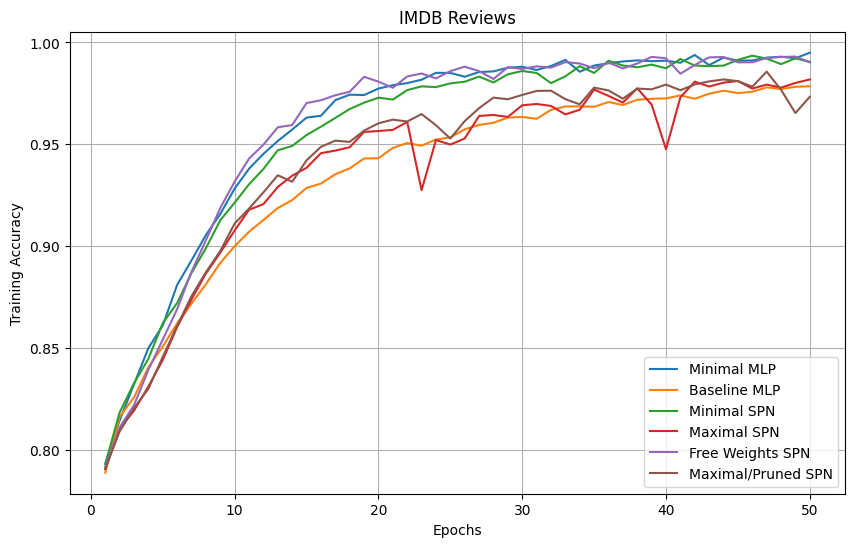

In [74]:
# Plot the training accuracy of all 5 models
plt.figure(figsize=(10, 6))

plt.plot(epochs, train_acc_0, label='Minimal MLP')
plt.plot(epochs, train_acc_1, label='Baseline MLP')
plt.plot(epochs, train_acc_2, label='Minimal SPN')
plt.plot(epochs, train_acc_3, label='Maximal SPN')
plt.plot(epochs, train_acc_4, label='Free Weights SPN')
plt.plot(epochs, train_acc_5, label='Maximal/Pruned SPN')

# Adding labels and title
plt.xlabel('Epochs')
plt.ylabel('Training Accuracy')
plt.title('IMDB Reviews')

# Adding a legend to distinguish the models
plt.legend()

# Show the plot
plt.grid(True)

#save the plot
plt.savefig('results/IMDB/training_accuracy_plot.png')  # Save as PNG file
plt.show()

In [75]:
test_acc_0 = val_metrics_0[:, 1]
test_acc_1 = val_metrics_1[:, 1]
test_acc_2 = val_metrics_2[:, 1]
test_acc_3 = val_metrics_3[:, 1]
test_acc_4 = val_metrics_4[:, 1]
test_acc_5 = val_metrics_5[:, 1]

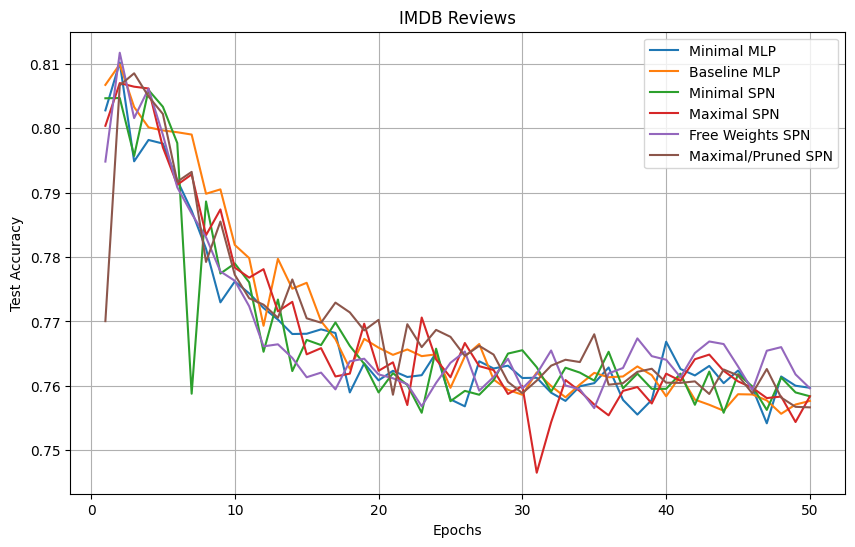

In [76]:
# Plot the testing accuracy of all 5 models
plt.figure(figsize=(10, 6))

plt.plot(epochs, test_acc_0, label='Minimal MLP')
plt.plot(epochs, test_acc_1, label='Baseline MLP')
plt.plot(epochs, test_acc_2, label='Minimal SPN')
plt.plot(epochs, test_acc_3, label='Maximal SPN')
plt.plot(epochs, test_acc_4, label='Free Weights SPN')
plt.plot(epochs, test_acc_5, label='Maximal/Pruned SPN')

# Adding labels and title
plt.xlabel('Epochs')
plt.ylabel('Test Accuracy')
plt.title('IMDB Reviews')

# Adding a legend to distinguish the models
plt.legend()

# Show the plot
plt.grid(True)

#save the plot
plt.savefig('results/IMDB/test_accuracy_plot.png')  # Save as PNG file
plt.show()

In [77]:
# List of all test accuracies
test_accuracies = [test_acc_0, test_acc_1, test_acc_2, test_acc_3, test_acc_4, test_acc_5]

# Find the index of the best (maximum) accuracy for each model
best_accuracy_indices = [np.argmax(acc) + 1 for acc in test_accuracies]

In [78]:
time_to_best_acc_0 = train_metrics_0[:best_accuracy_indices[0], 0].sum()
time_to_best_acc_1 = train_metrics_1[:best_accuracy_indices[1], 0].sum()
time_to_best_acc_2 = train_metrics_2[:best_accuracy_indices[2], 0].sum()
time_to_best_acc_3 = train_metrics_3[:best_accuracy_indices[3], 0].sum()
time_to_best_acc_4 = train_metrics_4[:best_accuracy_indices[4], 0].sum()
time_to_best_acc_5 = train_metrics_5[:best_accuracy_indices[5], 0].sum()

best_test_acc_0 = test_acc_0[best_accuracy_indices[0] - 1]
best_test_acc_1 = test_acc_1[best_accuracy_indices[1] - 1]
best_test_acc_2 = test_acc_2[best_accuracy_indices[2] - 1]
best_test_acc_3 = test_acc_3[best_accuracy_indices[3] - 1]
best_test_acc_4 = test_acc_4[best_accuracy_indices[4] - 1]
best_test_acc_5 = test_acc_5[best_accuracy_indices[5] - 1]

In [79]:
summary_0 = ['Minimal MLP', param_count_0, best_test_acc_0, time_to_best_acc_0, best_test_acc_0 / time_to_best_acc_0]
summary_1 = ['Baseline MLP', param_count_1, best_test_acc_1, time_to_best_acc_1, best_test_acc_1 / time_to_best_acc_1]
summary_2 = ['Minimal SPN', param_count_2, best_test_acc_2, time_to_best_acc_2, best_test_acc_2 / time_to_best_acc_2]
summary_3 = ['Maximal SPN', param_count_3, best_test_acc_3, time_to_best_acc_3, best_test_acc_3 / time_to_best_acc_3]
summary_4 = ['Free Weights SPN', param_count_4, best_test_acc_4, time_to_best_acc_4, best_test_acc_4 / time_to_best_acc_4]
summary_5 = ['Maximal/Pruned SPN', param_count_5, best_test_acc_5, time_to_best_acc_5, best_test_acc_5 / time_to_best_acc_5]

In [80]:
import pandas as pd

# Combine all summaries into a list of lists (each summary as a row)
summaries = [summary_0, summary_1, summary_2, summary_3, summary_4, summary_5]

# Create a DataFrame
df = pd.DataFrame(summaries, columns=['Model', 'Parameter Count', 'Best Test Accuracy', 'Time to Best Test Accuracy', 'Efficiency'])

# Set the display options to allow for better fitting
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', 1000)  # Increase the width so it can fit more columns
pd.set_option('display.max_colwidth', None)  # Allow unlimited column width

# Now when you print the DataFrame, it will be displayed as a continuous table
print(df)

                Model  Parameter Count  Best Test Accuracy  Time to Best Test Accuracy  Efficiency
0         Minimal MLP            37154             0.81024                    1.645893    0.492280
1        Baseline MLP            26786             0.80996                    2.040096    0.397020
2         Minimal SPN            37922             0.80596                    3.418468    0.235766
3         Maximal SPN            42483             0.80704                   71.794796    0.011241
4    Free Weights SPN            39970             0.81176                    3.715089    0.218504
5  Maximal/Pruned SPN            42448             0.80856                   87.536190    0.009237


In [81]:
df.to_csv('results/IMDB/model_summary.csv', index=False)